In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import thermogram_utilities

from tabulate import tabulate
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")
df['CancerType'] = np.where(df['CancerType'].isna(), 'Control', df['CancerType'])


## Introduction
Thermal liquid biopsy (TLB) is a growing field of biochemistry that holds potential to be used as a tool to diagnose and monitor disease. Thermograms, which are the results of TLB, differ based on the health status of a patient, and can be used to train classification models to identify an illness. This report details the work that has been done with Lung Cancer (LC) Thermograms during the Fall 2023 semester. The goal of this work was to use machine learning to train classification models to identify LC diagnosis and stage using TLB. First, feature selection was used to identify any bias in the thermograms, then random forests were cross-validated to train classification models to identify cancer type and stage. Table 1 shows the LC types and frequencies included in the dataset.
\
\
Figure 1 shows the median thermogram for each LC type. It can be seen that the median curves present differently for each type of LC. Despite the differences in the median curves, variation in individual samples is high. Figure 2 shows the median thermogram curve, as well as the 5th and 95th quantiles observed. The variation of individual samples within each group suggests that classification using thermograms will be difficult.

## Thermogram Feature Importance
Due to the way TLB is collected, identifying where the tails of a thermogram begin involves human input. As a result, evaluating any bias that exists in thermogram tails needed to be evaluated. This was done by selecting the two largest classes in the dataset, Control and Adenocarcinoma, and training a random forest to classify the type with and without the thermogram tails. Feature importance for each random forest was collected, and compared to determine if the presence of the tails were biasing a thermogram classification.
\
\
Figure 3 shows the mean feature importance of each temperature, including the tails (45-90&deg;C), for 1000 bootstrapped train test splits. Figure 4 shows the truncated thermogram temperatures, without the tails (51-83&deg;C), for 1000 bootstrapped train test splits. Feature importance in thermograms that contain the tails are concentrated in the ends, whereas when the tail are truncated, feature importance becomes more distributed across the entirety of the thermogram. This indicates that the tails are biased heavily influencing the outcome of a classification model. In order to prevent the tails from influencing models, all models presented in this report will contain temperatures 51-83&deg;C.

## Results of Pairwise Classifications
For all LC types with 10 or more thermograms, pairwise classifications were conducted. 1,000 iterations of bootstrap cross-validation (BSCV) was utilized to evaluate random forest model performance. For each bootstrapped sample, a grid of hyper parameter combinations was searched to find the best version. The parameters that were evaluated were the number of trees, the number of features, and tree depth. The hyper parameter states were grouped together, and the combination with the highest balanced accuracy was selected as the final model for each combination. Table 2 shows the results of each cancer type combination that were classified. Balanced accuracy was used as the primary metric for evaluating performance because it accounts for class imbalance. The balanced accuracy ranges from 0.51 - 0.67. The poor model performance for each cancer pair is not surprising given the large amount of thermogram overlap between cancer type.

## Results of Stage Prediction
Thermograms were also used to predict lung cancer stage. Early vs late stages were predicted , as well as stages 1-4 for each cancer type for each cancer type with 10 or more samples. Table 3 and 4 shows the groups and counts for each stage. Figure 5 shows the median thermograms for each cancer and stage. Due to limited sample sizes, cancer types with thermograms that are particularly distinct, such as Large Cell, were not included in classification pairs. 
\
\
 Table 4 indicates that thermograms cannot be used to predict early vs late stage within individual cancer types, and also cannot be used to predict early vs late across all groups due to the low balanced accuarcies observed. Again, this is not surprising given how similar each cancer stage is to the other.
 \
 \
 Finally, a multiclassifier was used to predict stages 1-4. BSCV was utilized to evaluate model performance, and a grid search for hyper parameters was used to find the optimal model. Table 5 shows the sample size for each group and stage. Table 6 shows that LC thermograms are not useful in classification problems with respect to stage. With balanced accuracies between 0.329 and 0.367, the models did not perform well predicting cancer stages. Classifiers were trained on lung cancer thermograms to identify cancer type, early/late stage, and stages 1-4 for each cancer type. 

## Conclusion
Despite initial visualization, analysis of LC thermograms indicate that they contain bias, and do not perform well in a classification problem. When evaluating feature importance in classifiers trained with and without tails, models that included the tails had high feature importance values concentrated at the ends the thermograms, and models trained without tail had feature importance values that were distributed across thermograms. Additionally, cross-validated random forests did not perform well classifying lung cancer type or stage, indicating that LC thermograms are not distinct enough to be used in classification problems.



In [2]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

In [3]:

# Get the value counts
counts = df["CancerType"].value_counts()

# Convert value counts to a DataFrame
counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['CancerType', 'Count']

table_label = "Table 1"
display(Markdown(f"##### {table_label}: Number of Lung Cancer Samples by Type"))

# Display the DataFrame with a custom column name
display(counts_df.rename(columns={'CancerType': 'Cancer Type'}))

##### Table 1: Number of Lung Cancer Samples by Type

,Cancer Type,Count
0,Adenocarcinoma,72
1,Control,51
2,Squamous,46
3,SCLC,16
4,NOS,8
5,Large cell,6


In [4]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

In [5]:
df_long = pd.melt(df, id_vars=['sample_id', 'pub_id', 'CancerType'], var_name='temp', value_name='dsp' )

# remove the "T" and set temp column to numeric
df_long['temp'] = df_long['temp'].str.replace('T', '')
df_long = df_long.astype({"temp" : float})

df_median = thermogram_utilities.median_curve(df_long, 'CancerType', 'temp', 'dsp')


In [6]:
median_control = df_median[(df_median["type"] == "Control") | (df_median["type"] == "Adenocarcinoma")]

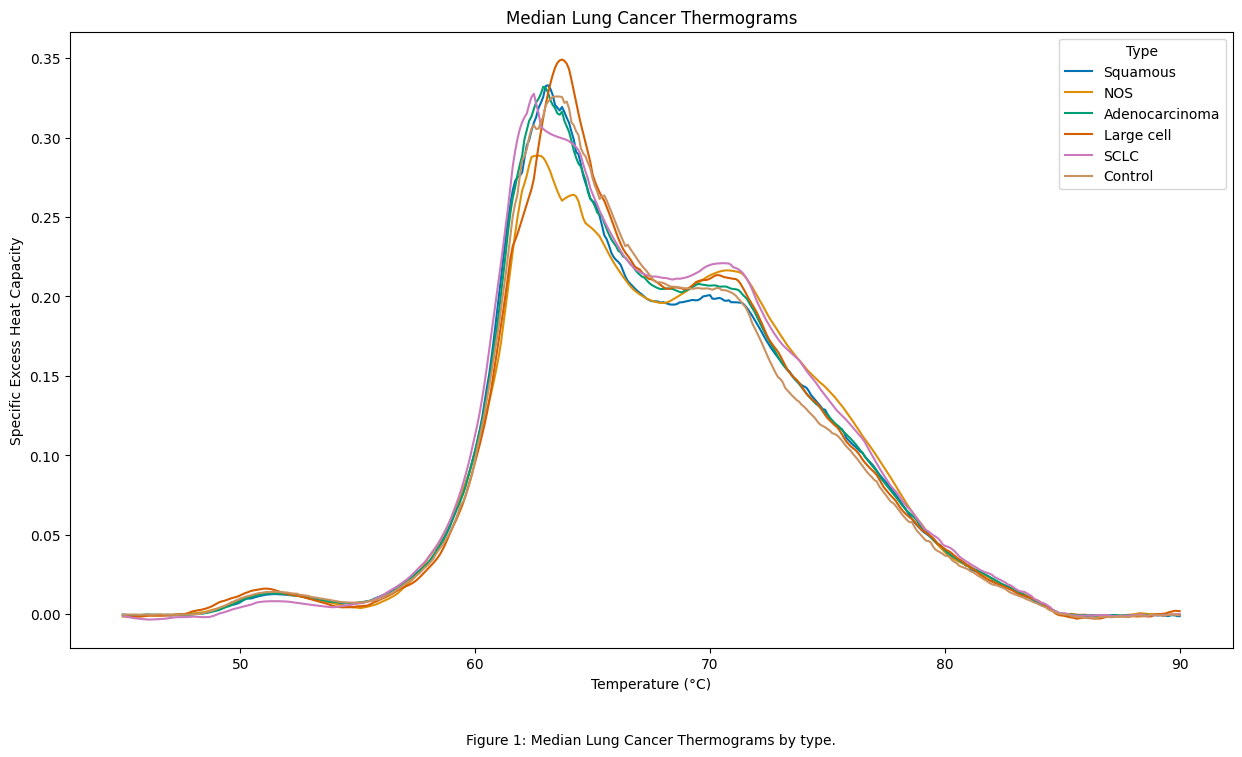

In [7]:
plt.figure(figsize=(15, 8))  # Adjust the figure size as needed
sns.lineplot(data=df_median, x='temperature', y='median', hue='type', palette='colorblind')
plt.xlabel('Temperature (\u00b0C)')
plt.ylabel('Specific Excess Heat Capacity')
plt.title('Median Lung Cancer Thermograms')
plt.legend(title='Type')
plt.text(0.5, -0.15, 'Figure 1: Median Lung Cancer Thermograms by type.', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [8]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

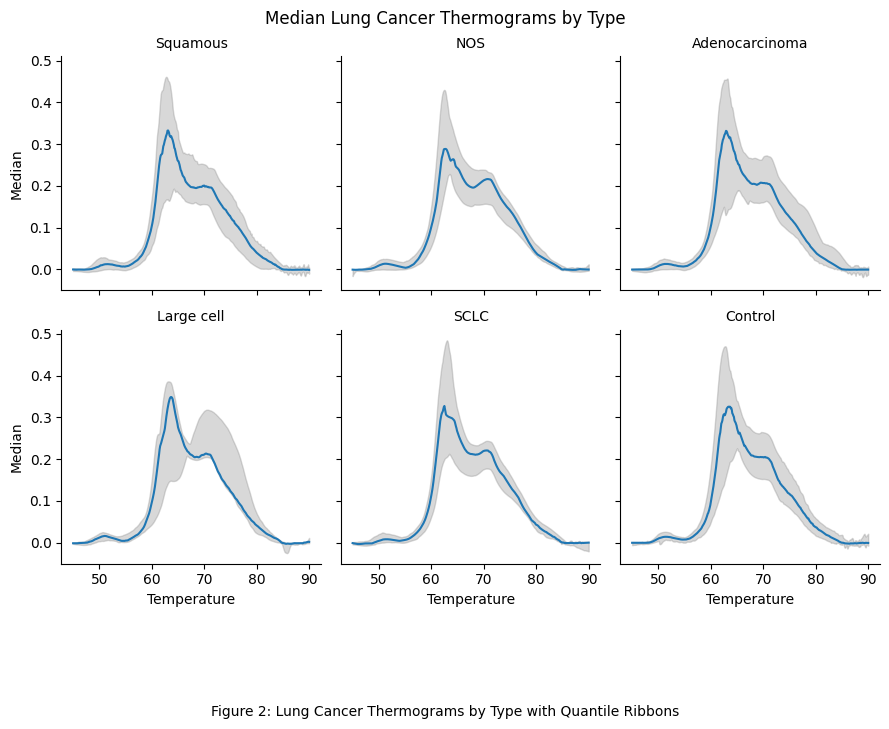

In [9]:
# Assuming df_median is your DataFrame
median_df = df_median

# courtesy of chatGPT
g = sns.FacetGrid(median_df, col="type", col_wrap=3, palette='colorblind')

g.set_axis_labels("Temperature", "Median")
g.set_titles(col_template="{col_name}")

# Define a custom function to add the ribbon to each panel
def add_ribbon(**kwargs):
    ax = plt.gca()
    panel_data = kwargs.pop("data")  # Get the data specific to the current panel
    
    sns.lineplot(data=panel_data, x='temperature', y='median', ax=ax, palette='colorblind')
    ax.fill_between(panel_data['temperature'], panel_data['lower_q'], panel_data['upper_q'], alpha=0.3, color='gray')

# Use FacetGrid.map_dataframe to apply the custom function to each panel
g.map_dataframe(add_ribbon)

# Add figure number and caption
plt.text(0.5, -0.15, 'Figure 2: Lung Cancer Thermograms by Type with Quantile Ribbons', ha='center', va='center', transform=g.fig.transFigure)
g.fig.suptitle("Median Lung Cancer Thermograms by Type", y=1.02)
# Show the plot
plt.show()


In [10]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

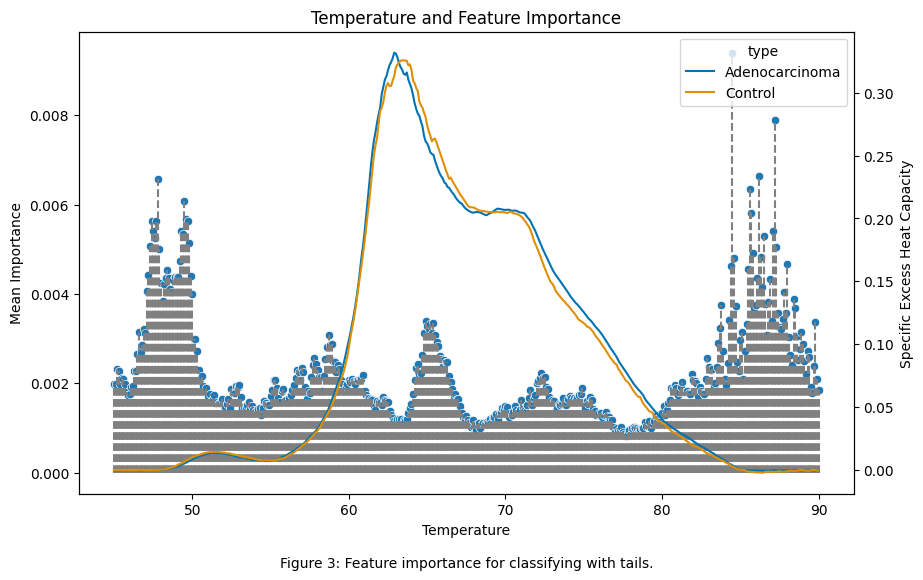

In [11]:
mean_feature_importance = pd.read_excel("mean_feature_importance_tails.xlsx")
median_df = median_control

plt.figure(figsize=(10, 6))

# create a bar plot
sns.scatterplot(data=mean_feature_importance, x='Temperature', y="Mean Importance")

for index, row in mean_feature_importance.iterrows():
    x_value = row['Temperature']
    y_value = row["Mean Importance"]
    
    # Add a vertical line from the point to the x-axis
    plt.plot([x_value, x_value], [0, y_value], color='gray', linestyle='--')


ax2 = plt.gca().twinx()

p = sns.lineplot(data=median_df, x='temperature', y='median',ax=ax2, hue='type', palette='colorblind')


# add labels and title
plt.xlabel('Temperature')
plt.ylabel('Mean Importance')
ax2.set_ylabel('Specific Excess Heat Capacity')
plt.title('Temperature and Feature Importance')
plt.text(0.5, -0.15, 'Figure 3: Feature importance for classifying with tails.', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

In [12]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

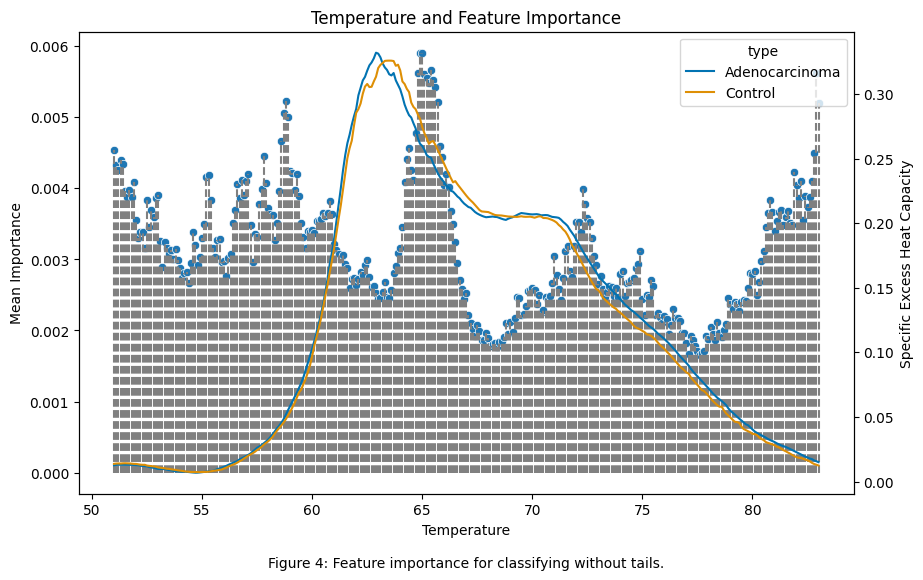

In [13]:
median_df = median_control[(median_control['temperature'] >= 51) & (median_control['temperature'] <= 83)]

mean_feature_importance = pd.read_excel("mean_feature_importance_no_tails.xlsx")
plt.figure(figsize=(10, 6))

# create a bar plot
sns.scatterplot(data=mean_feature_importance, x='Temperature', y="Mean Importance")

for index, row in mean_feature_importance.iterrows():
    x_value = row['Temperature']
    y_value = row["Mean Importance"]
    
    # Add a vertical line from the point to the x-axis
    plt.plot([x_value, x_value], [0, y_value], color='gray', linestyle='--')


ax2 = plt.gca().twinx()

p = sns.lineplot(data=median_df, x='temperature', y='median',ax=ax2, hue='type', palette='colorblind')


# add labels and title
plt.xlabel('Temperature')
plt.ylabel('Mean Importance')
ax2.set_ylabel('Specific Excess Heat Capacity')
plt.title('Temperature and Feature Importance')
plt.text(0.5, -0.15, 'Figure 4: Feature importance for classifying without tails.', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

In [14]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

In [15]:
results_table = pd.DataFrame(columns=["Pair", "Weighted Accuracy", "AUC"])

# adeno vs sclc results
adeno_sclc_1 = pd.read_excel("Adeno_SCLC.xlsx")
adeno_sclc_2 = pd.read_excel("Adeno_SCLC_1.xlsx")
adeno_sclc = pd.concat([adeno_sclc_1, adeno_sclc_2], ignore_index = True)

adeno_sclc['max_depth'] = np.where(pd.isna(adeno_sclc['max_depth']), "None", adeno_sclc["max_depth"])
adeno_sclc['max_features'] = np.where(pd.isna(adeno_sclc['max_features']), "None", adeno_sclc["max_features"])

adeno_sclc_results = adeno_sclc.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)
new_row = pd.DataFrame([["Adeno - SCLC", adeno_sclc_results.iloc[0]["Weighted Accuracy"], adeno_sclc_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])

results_table = pd.concat([results_table, new_row], ignore_index=True)

In [16]:
adeno_squamous = pd.read_excel("Adeno_Squamous.xlsx")

adeno_squamous['max_depth'] = np.where(pd.isna(adeno_squamous['max_depth']), "None", adeno_squamous["max_depth"])
adeno_squamous['max_features'] = np.where(pd.isna(adeno_squamous['max_features']), "None", adeno_squamous["max_features"])

adeno_squamous_results = adeno_squamous.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)

new_row = pd.DataFrame([["Adeno - Squamous", adeno_squamous_results.iloc[0]["Weighted Accuracy"], adeno_squamous_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])

results_table = pd.concat([results_table, new_row], ignore_index=True)


In [17]:
adeno_control = pd.read_excel("Adeno_Control.xlsx")

adeno_control['max_depth'] = np.where(pd.isna(adeno_control['max_depth']), "None", adeno_control["max_depth"])
adeno_control['max_features'] = np.where(pd.isna(adeno_control['max_features']), "None", adeno_control["max_features"])

adeno_control_results = adeno_control.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)

new_row = pd.DataFrame([["Adeno - Control", adeno_control_results.iloc[0]["Weighted Accuracy"], adeno_control_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])

results_table = pd.concat([results_table, new_row], ignore_index=True)

In [18]:
squamous_sclc = pd.read_excel("Squamous_SCLC.xlsx")

squamous_sclc['max_depth'] = np.where(pd.isna(squamous_sclc['max_depth']), "None", squamous_sclc["max_depth"])
squamous_sclc['max_features'] = np.where(pd.isna(squamous_sclc['max_features']), "None", squamous_sclc["max_features"])

squamous_sclc_results = squamous_sclc.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)

new_row = pd.DataFrame([["Squamous - SCLC", squamous_sclc_results.iloc[0]["Weighted Accuracy"], squamous_sclc_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])

results_table = pd.concat([results_table, new_row], ignore_index=True)

In [19]:
squamous_control = pd.read_excel("Control_Squamous.xlsx")

squamous_control['max_depth'] = np.where(pd.isna(squamous_control['max_depth']), "None", squamous_control["max_depth"])
squamous_control['max_features'] = np.where(pd.isna(squamous_control['max_features']), "None", squamous_control["max_features"])

squamous_control_results = squamous_control.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)

new_row = pd.DataFrame([["Squamous - Control", squamous_control_results.iloc[0]["Weighted Accuracy"], squamous_control_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])

results_table = pd.concat([results_table, new_row], ignore_index=True)

In [20]:
control_sclc = pd.read_excel("Control_SCLC.xlsx")

control_sclc['max_depth'] = np.where(pd.isna(control_sclc['max_depth']), "None", control_sclc["max_depth"])
control_sclc['max_features'] = np.where(pd.isna(control_sclc['max_features']), "None", control_sclc["max_features"])

control_sclc_results = control_sclc.groupby(['n_estimators', 'max_depth', 'max_features']).mean().sort_values("Weighted Accuracy", ascending=False)
new_row = pd.DataFrame([["Control - SCLC", control_sclc_results.iloc[0]["Weighted Accuracy"], control_sclc_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])
results_table = pd.concat([results_table, new_row], ignore_index=True)

In [21]:
display(Markdown(f"##### {'Table 2'}: Classification Results per Cancer Pair"))


#results_table.sort_values(by="Weighted Accuracy", ascending=False, inplace=True)
results_table.sort_values(by="Weighted Accuracy", ascending=False, inplace=True)
results_table

##### Table 2: Classification Results per Cancer Pair

,Pair,Weighted Accuracy,AUC
5,Control - SCLC,0.677083,0.799829
4,Squamous - Control,0.588179,0.622351
2,Adeno - Control,0.575928,0.619652
3,Squamous - SCLC,0.541017,0.598070
0,Adeno - SCLC,0.530405,0.593018
1,Adeno - Squamous,0.513628,0.524180


In [22]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

In [23]:
prev = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")
update = pd.read_excel('/Users/avery/OneDrive/Documents/publication_meta_data.xlsx')
merged = pd.merge(prev, update, left_on='pub_id', right_on="Patient")
df = merged.drop(["CancerType", "sample_id", "pub_id", "Patient"], axis = 1)
display(Markdown(f"##### {'Table 3'}: Classification Results per Cancer Pair"))

pd.DataFrame(df.groupby("Diagnosis")["Stage"].value_counts())

##### Table 3: Classification Results per Cancer Pair

count
Diagnosis Stage       
AC        Early     36
          Late      34
Large     Early      4
          Late       2
Mix       Early      1
          Late       1
NOS       Late       6
          Early      2
SCC       Early     23
          Late      23
SCLC      Early     11
          Late       5

In [24]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

In [25]:
cancer_type = "Control"
prediction_df = df.loc[df["Diagnosis"] != cancer_type]
#prediction_df["Stage"] = np.where(prediction_df["Stage"] == "Early", 0, 1)

prediction_df["Cancer and Stage"] = prediction_df["Diagnosis"] + "_" + prediction_df["Stage"]
prediction_df = prediction_df.drop(["Diagnosis", "Stage"], axis = 1)


df_long = pd.melt(prediction_df, id_vars=['Cancer and Stage'], var_name='temp', value_name='dsp' )

median = thermogram_utilities.median_curve(df_long, 'Cancer and Stage', 'temp', 'dsp')

median['temperature'] = median['temperature'].str.replace('T', '').astype(float)

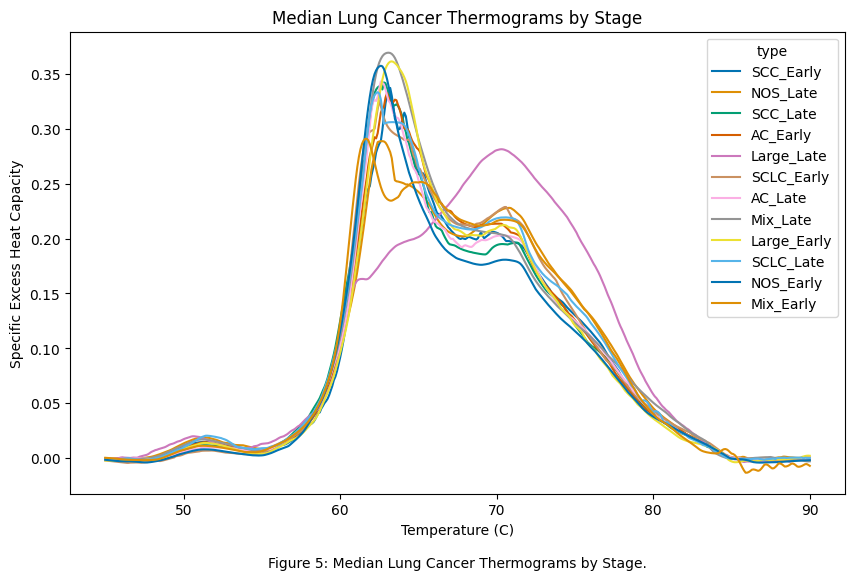

In [26]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(data=median, x='temperature', y='median', hue='type', palette='colorblind')
plt.xlabel('Temperature (C)')
plt.ylabel('Specific Excess Heat Capacity')
plt.title('Median Lung Cancer Thermograms by Stage')
plt.text(0.5, -0.15, 'Figure 5: Median Lung Cancer Thermograms by Stage.', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

In [27]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

In [28]:
adeno_stage = pd.read_excel("AC_Stage_Results.xlsx")

adeno_stage['max_depth'] = np.where(pd.isna(adeno_stage['max_depth']), "None", adeno_stage["max_depth"])
adeno_stage['max_features'] = np.where(pd.isna(adeno_stage['max_features']), "None", adeno_stage["max_features"])

adeno_stage_results = adeno_stage.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)


In [29]:
scc_stage = pd.read_excel("SCC_Stage_Results.xlsx")

scc_stage['max_depth'] = np.where(pd.isna(scc_stage['max_depth']), "None", scc_stage["max_depth"])
scc_stage['max_features'] = np.where(pd.isna(scc_stage['max_features']), "None", scc_stage["max_features"])

scc_stage_results = scc_stage.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)

In [30]:
sclc_stage = pd.read_excel("SCLC_Stage_Results.xlsx")

sclc_stage['max_depth'] = np.where(pd.isna(sclc_stage['max_depth']), "None", sclc_stage["max_depth"])
sclc_stage['max_features'] = np.where(pd.isna(sclc_stage['max_features']), "None", sclc_stage["max_features"])

sclc_stage_results = sclc_stage.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)

In [31]:
all_stage = pd.read_excel("ALL_Stage_Results.xlsx")

all_stage['max_depth'] = np.where(pd.isna(all_stage['max_depth']), "None", all_stage["max_depth"])
all_stage['max_features'] = np.where(pd.isna(all_stage['max_features']), "None", all_stage["max_features"])

all_stage_results = all_stage.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)


In [32]:
results = pd.concat([adeno_stage_results.head(1), scc_stage_results.head(1), sclc_stage_results.head(1), all_stage_results.head(1)], ignore_index=True)
#results = results.drop("Type", axis=1)
results.insert(0, "Type", ["AC", "SCC", "SCLC", "All"])
results = results.drop(["n_estimators", "max_depth", "max_features"], axis = 1)

In [33]:
display(Markdown(f"##### {'Table 4'}: Classification Results per Cancer Type for Early vs Late Stage"))
results

##### Table 4: Classification Results per Cancer Type for Early vs Late Stage

,Type,Weighted Accuracy,AUC
0,AC,0.550638,0.584997
1,SCC,0.508604,0.505465
2,SCLC,0.597812,0.684095
3,All,0.544999,0.561948


In [34]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

In [35]:
prev = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")
substages = pd.read_excel("patient_substage.xlsx")
stage_df = pd.merge(prev, substages, left_on = "pub_id", right_on = "pub_id")

In [36]:
lower_column_index = stage_df.columns.get_loc("T51")
upper_column_index = stage_df.columns.get_loc("T83.1")
label_column_index = stage_df.columns.get_loc("Diagnosis")
cancer_column_index = stage_df.columns.get_loc("Current Clinical Stage")

column_indices = np.arange(lower_column_index, upper_column_index)
column_indices = np.append(column_indices, label_column_index)
column_indices = np.append(column_indices, cancer_column_index)


stage_df = stage_df.iloc[:, column_indices]

# keep only Control and Adenocarcinoma for analysis
stage_df = stage_df.reset_index(drop=True)



In [37]:
display_df = stage_df[(stage_df["Diagnosis"] != "Control") & (stage_df["Diagnosis"] != "SCLC")]
display(Markdown(f"##### {'Table 5'}: Stages for Each Cancer Type"))

pd.DataFrame(display_df.groupby("Diagnosis")["Current Clinical Stage"].value_counts().sort_index(level=[0, 1]))


##### Table 5: Stages for Each Cancer Type

count
Diagnosis Current Clinical Stage       
AC        1                          16
          2                          10
          3                          15
          4                          29
Large     1                           2
          2                           2
          4                           2
Mix       3                           1
          4                           1
NOS       1                           1
          3                           1
          4                           6
SCC       1                           7
          2                           8
          3                          16
          4                          15

In [38]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

In [39]:
stage_df["cancer stage"] = stage_df["Diagnosis"] +"_" + stage_df["Current Clinical Stage"]
stage_df_long = pd.melt(stage_df, id_vars=['Current Clinical Stage', 'Diagnosis', 'cancer stage'], var_name = "temp", value_name="dsp")
stage_df_long["temp"] = stage_df_long["temp"].str.replace("T", "")
stage_df_long["temp"] = stage_df_long["temp"].astype(float)


In [40]:
AC_results = pd.read_excel("AC_Stage.xlsx")

AC_results['max_depth'] = np.where(pd.isna(AC_results['max_depth']), "None", AC_results["max_depth"])
AC_results['max_features'] = np.where(pd.isna(AC_results['max_features']), "None", AC_results["max_features"])
adeno_results = AC_results.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)


In [41]:
SCC_results = pd.read_excel("SCC_Stage.xlsx")

SCC_results['max_depth'] = np.where(pd.isna(SCC_results['max_depth']), "None", SCC_results["max_depth"])
SCC_results['max_features'] = np.where(pd.isna(SCC_results['max_features']), "None", SCC_results["max_features"])
scc_results = SCC_results.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)


In [42]:
all_results = pd.read_excel("All_Stage.xlsx")

all_results['max_depth'] = np.where(pd.isna(all_results['max_depth']), "None", all_results["max_depth"])
all_results['max_features'] = np.where(pd.isna(all_results['max_features']), "None", all_results["max_features"])
all_results = all_results.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)


In [43]:
results = pd.concat([adeno_results.head(1), scc_results.head(1),  all_results.head(1)], ignore_index=True)
#results = results.drop("Type", axis=1)
results.insert(0, "Type", ["AC", "SCC", "All"])
results = results.drop(["n_estimators", "max_depth", "max_features"], axis = 1)
display(Markdown(f"##### {'Table 6'}: Classification Results per Cancer Stage 1-4"))

pd.DataFrame(results)

##### Table 6: Classification Results per Cancer Stage 1-4

,Type,Weighted Accuracy,AUC
0,AC,0.367951,0.624821
1,SCC,0.329758,0.605949
2,All,0.339149,0.622328
